In [3]:
import torch
import torch.nn.functional as F
from torch import nn

from einops import rearrange
from einops.layers.torch import Rearrange

from traj_dataset import TrajDataset
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD, Adagrad
from torch.nn import MSELoss
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader

from model import SimpleViT













In [4]:


device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
model = SimpleViT(dim=512,device=device,dim_head=64,mlp_dim=512,frame_patch_size=4,image_patch_size=(8,8))
model.load_state_dict(torch.load("/waldo/walban/student_datasets/arfranck/model_saves/epochs_50_lr_0.0001-12-06-2023-12:49:39.dict"))
loss_evol = []

test_loss = []







Using device: cuda:2


In [26]:
size = "64_64_4"
#folders = [f"bookstore/video0/" for k in range(1)]
#folders += [f"coupa/video{k}/" for k in range(4)]
#folders += [f"quad/video{k}/" for k in range(1)]
#folders += [f"gates/video{k}/" for k in range(9)]
folders = [f"deathCircle/video3/" for k in range(1)]
#folders += [f"little/video{k}/" for k in range(4)]
#folders += [f"nexus/video{k}/" for k in range(10)]

#folders = ["hyang/video1/"]

n_trajs = [(0, 20) for k in range(len(folders))]
data_folders = ["/waldo/walban/student_datasets/arfranck/SDD/scenes/" + folder + size for folder in folders]

dataset = TrajDataset(data_folders, n_trajs=n_trajs, n_prev=8, n_next=8, img_step=30)
train_data, validation_data, test_data = random_split(dataset, [0.9, 0.05, 0.05],generator=torch.Generator().manual_seed(42))




opening track 0 from /waldo/walban/student_datasets/arfranck/SDD/scenes/deathCircle/video3/64_64_4
opening track 1 from /waldo/walban/student_datasets/arfranck/SDD/scenes/deathCircle/video3/64_64_4
opening track 2 from /waldo/walban/student_datasets/arfranck/SDD/scenes/deathCircle/video3/64_64_4
opening track 3 from /waldo/walban/student_datasets/arfranck/SDD/scenes/deathCircle/video3/64_64_4
opening track 4 from /waldo/walban/student_datasets/arfranck/SDD/scenes/deathCircle/video3/64_64_4
opening track 5 from /waldo/walban/student_datasets/arfranck/SDD/scenes/deathCircle/video3/64_64_4
opening track 6 from /waldo/walban/student_datasets/arfranck/SDD/scenes/deathCircle/video3/64_64_4
opening track 7 from /waldo/walban/student_datasets/arfranck/SDD/scenes/deathCircle/video3/64_64_4
opening track 8 from /waldo/walban/student_datasets/arfranck/SDD/scenes/deathCircle/video3/64_64_4
opening track 9 from /waldo/walban/student_datasets/arfranck/SDD/scenes/deathCircle/video3/64_64_4
opening tr

In [27]:
batch_size = 1
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
criterion = MSELoss()


Test Batch 0
torch.Size([1, 8, 2])
0.12431931495666504
8


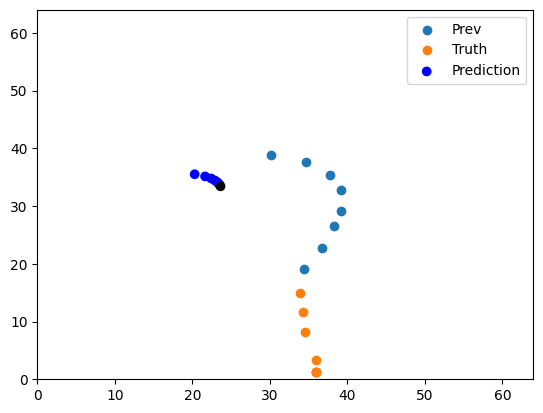

In [34]:
for id_b2, batch_test in enumerate(test_loader):


    with torch.no_grad():
        print(f"Test Batch {id_b2}")
        model.eval()

        X_test = batch_test["src"]
        Y_test = batch_test["tgt"]


        X_coords = batch_test["coords"]

        print(X_coords.shape)
        future = None
        
        for k in range(8):
            pred,output = model(X_test.to(device),future,train=False)
            future = output


        print(criterion(pred[0],Y_test[0].to(device)).item())
        prev = [(k[0]*64,k[1]*64) for k in X_coords[0]]
        points = [(k[0]*64,k[1]*64) for k in Y_test[0]]
        points2 = [(k[0]*64,k[1]*64) for k in pred[0].cpu().detach().numpy()]

        prev_x,prev_y = zip(*prev)
        x,y = zip(*points)
        x2,y2 = zip(*points2)
        print(len(points))

        plt.scatter([k for k in prev_x],[k for k in prev_y], label="Prev")
        plt.scatter([k for k in x],[k for k in y], label="Truth")
        plt.scatter([k for k in x2],[k for k in y2],label="Prediction",color=(["blue" for k in range(7)] + ["black"]))
        #plt.imread("reference.jpg")
        plt.legend()
        plt.xlim(0,64)
        plt.ylim(0,64)
        #plt.imshow(plt.imread("reference.jpg"))

        plt.savefig("/waldo/walban/student_datasets/arfranck/SDD/plots/test_3.pdf")
        plt.show()
        
        
        break
        

        
        